In [87]:
from langchain_core.messages import HumanMessage, BaseMessage, AIMessage
# from decouple import config
import pprint
import os
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from gemini_llm import GeminiLLM
import concurrent.futures
import json


In [88]:
from dotenv import load_dotenv
load_dotenv()

True

In [89]:
os.environ["GOOGLE_API_KEY"] = os.getenv("OPENAI_API_KEY") ## Put your OpenAI API key here
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY") ## Put your Langsmith API key here
os.environ["LANGCHAIN_HUB_API_KEY"] = os.getenv("LANGCHAIN_API_KEY") ## Put your Langsmith API key here
os.environ["LANGCHAIN_TRACING_V2"] = 'true' ## Set this as True
os.environ["LANGCHAIN_ENDPOINT"] = 'https://api.smith.langchain.com/' ## Set this as: https://api.smith.langchain.com/
os.environ["LANGCHAIN_HUB_API_URL"] = 'https://api.hub.langchain.com' ## Set this as : https://api.hub.langchain.com
os.environ["LANGCHAIN_PROJECT"] = 'llm-agents-planning'

## Define prompts for Generation, Reflection and Tool Execution

![Reflexion](images/Reflexion.png)

#### Generation Prompt

In [90]:
llm = GeminiLLM(model='gemini-1.5-flash-latest', temperature=0.3, response_mime_type='application/json')

In [110]:
generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an AI assistant researcher tasked with writing detailed 2-3 paragraph research on the topic presented by the user."
            "Along with the response, you will also give a list of 2-3 search suggestions that can be run to improve the research and ground it"
            "Give your output in JSON under 2 keys: 'answer' for your research response, 'search' for a list of search suggestions"
        ),
        (
            "user",
            "Write a report on the topic {task}"

        ),
    ]
)

generate_agent = generation_prompt | llm

In [111]:
result = generate_agent.invoke({"task": "Is the pace of climate change accelerating?"})
result = json.loads(result)
pprint.pprint(result)

{'answer': 'The pace of climate change is undeniably accelerating, evidenced '
           'by a multitude of indicators. Global average temperatures are '
           'rising at an unprecedented rate, with the past decade witnessing '
           'the warmest years on record. This warming trend is driving more '
           'frequent and intense heatwaves, droughts, and wildfires. '
           'Additionally, sea levels are rising at an accelerating pace due to '
           'melting glaciers and thermal expansion of ocean water. The '
           'frequency and severity of extreme weather events, such as '
           'hurricanes and floods, are also increasing, causing significant '
           'economic and societal disruptions. These trends are consistent '
           'with projections from climate models, which indicate that the rate '
           'of climate change will continue to accelerate in the coming '
           'decades unless drastic measures are taken to reduce greenhouse gas '


In [112]:
initial_report = result['answer']
print(initial_report)

The pace of climate change is undeniably accelerating, evidenced by a multitude of indicators. Global average temperatures are rising at an unprecedented rate, with the past decade witnessing the warmest years on record. This warming trend is driving more frequent and intense heatwaves, droughts, and wildfires. Additionally, sea levels are rising at an accelerating pace due to melting glaciers and thermal expansion of ocean water. The frequency and severity of extreme weather events, such as hurricanes and floods, are also increasing, causing significant economic and societal disruptions. These trends are consistent with projections from climate models, which indicate that the rate of climate change will continue to accelerate in the coming decades unless drastic measures are taken to reduce greenhouse gas emissions.


#### Tool Usage node

In [94]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=3)

In [113]:
tool.invoke({"query": "Global temperature trends past decade"})

[{'url': 'https://climate.nasa.gov/vital-signs/global-temperature/?intent=121',
  'content': 'Overall, Earth was about 2.45 degrees Fahrenheit (or about 1.36 degrees Celsius) warmer in 2023 than in the late 19th-century (1850-1900) preindustrial average. The 10 most recent years are the warmest on record. The animation on the right shows the change in global surface temperatures. Dark blue shows areas cooler than average.'},
 {'url': 'https://earthobservatory.nasa.gov/world-of-change/global-temperatures',
  'content': 'The leveling off of temperatures in the middle of the 20th century can be explained by natural variability and by the cooling effects of aerosols generated by factories, power plants, and motor vehicles in the years of rapid economic growth after World War II. The energy coming from the Sun fluctuates very little by year, while the amount of energy radiated by Earth is closely tied to the chemical composition of the atmosphere—particularly the amount of heat-trapping gre

In [114]:
def execute_single_search(query):
    tool = TavilySearchResults(max_results=3) ## Keep only top 3 results
    result =tool.invoke({"query":query})
    return result

def flatten_list(nested_list):
    return [item for sublist in nested_list for item in sublist]
    
def run_parallel_search(search_queries):
    with concurrent.futures.ThreadPoolExecutor(max_workers=len(search_queries)) as executor:
        # Submit the API calls to the executor
        outputs = [executor.submit(execute_single_search, point) for point in search_queries]
        # Wait for the API calls to complete and get the results
        results = [future.result() for future in concurrent.futures.as_completed(outputs)]

    flatten = flatten_list(results)
    return flatten


In [115]:
search_queries = ['Global temperature trends past decade', 'Sea level rise acceleration rate', 'Frequency and intensity of extreme weather events']
search_results = run_parallel_search(search_queries)

In [116]:
print(search_results)

[{'url': 'https://climate.nasa.gov/vital-signs/global-temperature/?intent=121', 'content': 'Overall, Earth was about 2.45 degrees Fahrenheit (or about 1.36 degrees Celsius) warmer in 2023 than in the late 19th-century (1850-1900) preindustrial average. The 10 most recent years are the warmest on record. The animation on the right shows the change in global surface temperatures. Dark blue shows areas cooler than average.'}, {'url': 'https://earthobservatory.nasa.gov/world-of-change/global-temperatures', 'content': 'The leveling off of temperatures in the middle of the 20th century can be explained by natural variability and by the cooling effects of aerosols generated by factories, power plants, and motor vehicles in the years of rapid economic growth after World War II. The energy coming from the Sun fluctuates very little by year, while the amount of energy radiated by Earth is closely tied to the chemical composition of the atmosphere—particularly the amount of heat-trapping greenhou

### Revision Request

In [117]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        #  this needs to be a tuple so do not forget the , at the end
        (
            "system",
            "You are an expert at revising research based on search results. Look at the current report, search queries and search results."
            "Use the search results to improve the report. Important: End your report by citing sources you used to write the report"
            "Also give me 2-3 search suggestions that will further improve the report. These should be different from the search queries that are already done"
            "Give your output in JSON under 2 keys: 'answer' for your research response with citation. Put citation URLs at the end., 'search' for a list of search suggestions"
        ),
        (
            "user",
            "The question from the user is {task}. The current report is {current_report} \n"
            "The search queries done so far are {search_queries}"
            "The search results are {search_results}"

        ),
    ]
)

reflect_agent = reflection_prompt | llm

In [118]:
result = reflect_agent.invoke({"task": "Is the pace of climate change accelerating?", "current_report": initial_report, "search_results": search_results, "search_queries": search_queries})
result = json.loads(result)
pprint.pprint(result)

{'answer': 'The pace of climate change is undeniably accelerating, evidenced '
           'by a multitude of indicators. Global average temperatures are '
           'rising at an unprecedented rate, with the past decade witnessing '
           'the warmest years on record.  The 10 most recent years are the '
           'warmest on record.  The warming trend is driving more frequent and '
           'intense heatwaves, droughts, and wildfires. Additionally, sea '
           'levels are rising at an accelerating pace due to melting glaciers '
           'and thermal expansion of ocean water. The frequency and severity '
           'of extreme weather events, such as hurricanes and floods, are also '
           'increasing, causing significant economic and societal disruptions. '
           'These trends are consistent with projections from climate models, '
           'which indicate that the rate of climate change will continue to '
           'accelerate in the coming decades unless d

## Setup Langgraph 

### Define state

In [101]:
from typing import List, Tuple, Annotated, TypedDict, Sequence
import operator
from langchain_core.messages import BaseMessage
from langgraph.graph import StateGraph, END


class AgentState(TypedDict):
    task: str
    current_report: str
    search_queries: list[str]
    search_results: list[str]
    revision_number: int
    max_revisions: int


In [102]:
def generation_node(state):
    result = generate_agent.invoke({"task": state['task']})
    result = json.loads(result)
    return {'current_report': result['answer'], 'search_queries': result['search'], 'revision_number': state.get('revision_number', 0)+1 }


def execute_search(state):
    search_qs = state['search_queries']
    search_results = run_parallel_search(search_qs)
    return {'search_results': search_results} 


def reflection_node(state):
    result = reflect_agent.invoke({"task": state['task'], "current_report": state['current_report'], "search_results": state['search_results'], "search_queries": state['search_queries']})
    result = json.loads(result)
    return {'current_report': result['answer'], 'search_queries': result['search'], 'revision_number': state.get('revision_number', 0)+1 }


In [103]:
builder = StateGraph(AgentState)
builder.add_node("generate", generation_node)
builder.add_node("execute_search", execute_search)
builder.add_node("reflect", reflection_node)
builder.set_entry_point("generate")


def should_continue(state):
    num_turns = state['revision_number']
    if num_turns > state['max_revisions']:
        return END
    return "execute_search"

builder.add_edge("generate", "execute_search")
builder.add_edge("execute_search", "reflect")
builder.add_conditional_edges("reflect", should_continue)
graph = builder.compile()

In [104]:
graph.get_graph().print_ascii()

                        +-----------+                   
                        | __start__ |                   
                        +-----------+                   
                              *                         
                              *                         
                              *                         
                        +----------+                    
                        | generate |*                   
                        +----------+ ***                
                       **               *****           
                     **                      ***        
                   **                           *****   
        +----------------+                           ** 
        | execute_search |                            * 
        +----------------+                            * 
          ***         **                              * 
         *              **                            * 
       **                 **   

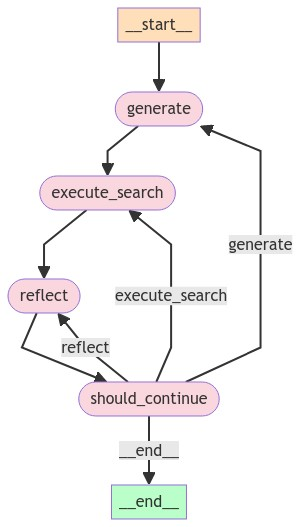

In [105]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [119]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'task': "How can we mitigate climate change?",
    "max_revisions": 3,
    "revision_number": 0,
}, thread):
    print(s)

Error in LangChainTracer.on_chain_end callback: AttributeError("'NoneType' object has no attribute 'append'")


{'generate': {'current_report': 'Climate change is a pressing global issue, and mitigating its effects requires a multifaceted approach encompassing individual, societal, and governmental actions.  One crucial strategy is transitioning to renewable energy sources like solar and wind power, reducing our reliance on fossil fuels that contribute significantly to greenhouse gas emissions.  Furthermore, promoting energy efficiency through building retrofits, sustainable transportation options, and responsible consumption patterns can significantly decrease our carbon footprint.  Investing in carbon capture and storage technologies can help remove existing carbon dioxide from the atmosphere, while reforestation and afforestation efforts play a vital role in absorbing carbon dioxide and mitigating climate change impacts.  International cooperation and policy frameworks are essential to address this global challenge, fostering collaboration and incentivizing sustainable practices across nation

Error in LangChainTracer.on_chain_end callback: AttributeError("'NoneType' object has no attribute 'append'")


{'reflect': {'current_report': 'Climate change is a pressing global issue that requires a multifaceted approach to mitigate its effects. One crucial strategy is transitioning to renewable energy sources like solar and wind power, reducing our reliance on fossil fuels that contribute significantly to greenhouse gas emissions. Promoting energy efficiency through building retrofits, sustainable transportation options, and responsible consumption patterns can significantly decrease our carbon footprint. Investing in carbon capture and storage technologies can help remove existing carbon dioxide from the atmosphere. Reforestation and afforestation efforts play a vital role in absorbing carbon dioxide and mitigating climate change impacts. International cooperation and policy frameworks are essential to address this global challenge, fostering collaboration and incentivizing sustainable practices across nations. \n\nLocal governments can play a significant role in mitigating climate change b

Error in LangChainTracer.on_chain_end callback: AttributeError("'NoneType' object has no attribute 'append'")


{'reflect': {'current_report': 'Climate change is a pressing global issue that requires a multifaceted approach to mitigate its effects. One crucial strategy is transitioning to renewable energy sources like solar and wind power, reducing our reliance on fossil fuels that contribute significantly to greenhouse gas emissions. Promoting energy efficiency through building retrofits, sustainable transportation options, and responsible consumption patterns can significantly decrease our carbon footprint. Investing in carbon capture and storage technologies can help remove existing carbon dioxide from the atmosphere. Reforestation and afforestation efforts play a vital role in absorbing carbon dioxide and mitigating climate change impacts. International cooperation and policy frameworks are essential to address this global challenge, fostering collaboration and incentivizing sustainable practices across nations. \n\nLocal governments can play a significant role in mitigating climate change b

Error in LangChainTracer.on_chain_end callback: AttributeError("'NoneType' object has no attribute 'append'")


{'reflect': {'current_report': 'Climate change is a pressing global issue that requires a multifaceted approach to mitigate its effects. One crucial strategy is transitioning to renewable energy sources like solar and wind power, reducing our reliance on fossil fuels that contribute significantly to greenhouse gas emissions. Promoting energy efficiency through building retrofits, sustainable transportation options, and responsible consumption patterns can significantly decrease our carbon footprint. Investing in carbon capture and storage technologies can help remove existing carbon dioxide from the atmosphere. Reforestation and afforestation efforts play a vital role in absorbing carbon dioxide and mitigating climate change impacts. International cooperation and policy frameworks are essential to address this global challenge, fostering collaboration and incentivizing sustainable practices across nations. [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]\n\nLocal governments can play a significant 

In [109]:
final_report = s['reflect']['current_report']
final_report

'Climate change is a pressing global issue that requires a multifaceted approach to mitigate its effects. One key strategy is reducing greenhouse gas emissions, primarily from burning fossil fuels. This involves transitioning to renewable energy sources like solar and wind power, improving energy efficiency in buildings and transportation, and promoting sustainable land use practices. [1, 2] Additionally, carbon capture and storage technologies can play a role in removing existing CO2 from the atmosphere. [3] Another crucial aspect is adaptation, which involves adjusting to the inevitable impacts of climate change. This includes building resilient infrastructure, developing drought-resistant crops, and implementing early warning systems for extreme weather events. [4, 5] Furthermore, international cooperation is vital for addressing climate change effectively. Global agreements like the Paris Agreement provide a framework for coordinated action, while financial assistance from develope